In [4]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.optimize import differential_evolution

In [6]:
# Load dataset
data = pd.read_csv("dataset_1.csv")  # Replace with your file path

In [8]:
# Feature selection
X = data[["Depth", "WOB", "SURF_RPM", "PHIF", "VSH"]]  # Input features
y = data["ROP_AVG"]  # Target feature

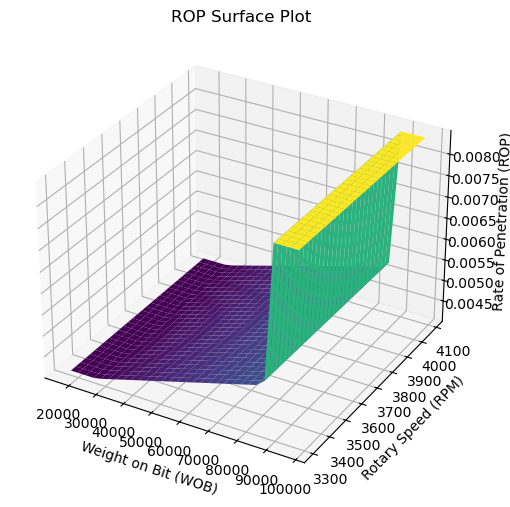

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data for 3D plot (150 rows)
WOB = data["WOB"].values
RPM = data["Depth"].values
ROP = data["ROP_AVG"].values

# Create a meshgrid for better visualization
WOB_grid, RPM_grid = np.meshgrid(np.linspace(min(WOB), max(WOB), 30), 
                                 np.linspace(min(RPM), max(RPM), 30))
ROP_grid = np.interp(WOB_grid, WOB, ROP)  # Interpolating ROP for visualization

# 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(WOB_grid, RPM_grid, ROP_grid, cmap="viridis", edgecolor="none")

ax.set_xlabel("Weight on Bit (WOB)")
ax.set_ylabel("Rotary Speed (RPM)")
ax.set_zlabel("Rate of Penetration (ROP)")
ax.set_title("ROP Surface Plot")
plt.show()

In [22]:

# Example data for 3D plot (assuming your dataset is named 'data')
WOB = data["WOB"].values
SURF_RPM = data["SURF_RPM"].values
ROP = data["ROP_AVG"].values

# Create a meshgrid for better visualization
WOB_grid, SURF_RPM_grid = np.meshgrid(np.linspace(min(WOB), max(WOB), 30), 
                                      np.linspace(min(SURF_RPM), max(SURF_RPM), 30))
ROP_grid = np.interp(WOB_grid, WOB, ROP)  # Interpolating ROP for visualization
ROP_grid = np.interp(SURF_RPM_grid, SURF_RPM, ROP_grid)

# 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(WOB_grid, SURF_RPM_grid, ROP_grid, cmap="viridis", edgecolor="none")

ax.set_xlabel("Weight on Bit (WOB)")
ax.set_ylabel("Surface RPM (SURF_RPM)")
ax.set_zlabel("Rate of Penetration (ROP)")
ax.set_title("ROP Surface Plot: WOB vs SURF_RPM")
plt.show()


ValueError: object too deep for desired array

In [8]:
# Normalize/Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Train an XGBoost surrogate model
surrogate_model = XGBRegressor(n_estimators=100, random_state=42)
surrogate_model.fit(X_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
# Define the objective function for Differential Evolution
def objective_function(x):
    # x is a 1D array of shape (n_dimensions,)
    # Reshape x to 2D array for scaling
    x_reshaped = np.array(x).reshape(1, -1)
    # Scale the input
    X_new = scaler.transform(x_reshaped)
    # Predict ROP_AVG using the XGBoost model
    rop = surrogate_model.predict(X_new)
    return -rop[0]  # Negative sign because DE minimizes the objective function

In [14]:
# Define parameter bounds
bounds = [
    (data["Depth"].min(), data["Depth"].max()),  # Bounds for Depth
    (data["WOB"].min(), data["WOB"].max()),      # Bounds for WOB
    (data["SURF_RPM"].min(), data["SURF_RPM"].max()),  # Bounds for SURF_RPM
    (data["PHIF"].min(), data["PHIF"].max()),    # Bounds for PHIF
    (data["VSH"].min(), data["VSH"].max())       # Bounds for VSH
]

In [16]:
# Run Differential Evolution
result = differential_evolution(objective_function, bounds, maxiter=100, popsize=15, seed=42)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature

In [18]:
# Extract the best parameters and ROP_AVG
best_params = result.x
best_rop = -result.fun  # Convert back to positive (since we minimized the negative)

In [20]:
# Print results
print("Best Parameters (Depth, WOB, SURF_RPM, PHIF, VSH):", best_params)
print("Optimized ROP_AVG:", best_rop)

Best Parameters (Depth, WOB, SURF_RPM, PHIF, VSH): [3.88612485e+03 3.12817574e+04 2.04964939e+00 1.34902746e-02
 4.67731969e-01]
Optimized ROP_AVG: 0.008572020567953587


In [23]:
Depth = 3.88612485e+03 
WOB = 3.12817574e+04 
SURF_RPM = 2.04964939e+00  
PHIF = 1.34902746e-02  
VSH= 4.67731969e-01

print(f" Best Parameters (Depth, WOB, SURF_RPM, PHIF, VSH): {Depth}, {WOB}, {SURF_RPM}, {PHIF}, {VSH}")

 Best Parameters (Depth, WOB, SURF_RPM, PHIF, VSH): 3886.12485, 31281.7574, 2.04964939, 0.0134902746, 0.467731969


In [27]:
# Evaluate baseline performance on the test set
from sklearn.model_selection import train_test_split

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Predict ROP_AVG for the test dataset
y_pred_test = surrogate_model.predict(X_test)

In [33]:
# Calculate Baseline ROP_AVG (mean of predictions on the test set)
baseline_rop_avg = np.mean(y_pred_test)

In [35]:
# Print baseline performance
print("Baseline ROP_AVG (Test Set):", baseline_rop_avg)

Baseline ROP_AVG (Test Set): 0.008342685
